In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
X = df[['param_1', 'param_2', 'param_3',
       'param_4','ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
       'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
       'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
       'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
       'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
       'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
       'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']].values
y = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
       'norm_cells_4', 'norm_cells_5']].values

print(X.shape)
print(y.shape)
num_conc=y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

(80, 28)
(80, 5)


In [4]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)


In [70]:
class HomemadeRBF(Kernel):\
#TODO embed the domain information
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define a hyperparameter called 'scale'
        self.homemade_lengthscale = torch.nn.Parameter(torch.tensor(1.0))
        
        # Register the hyperparameter
        self.register_parameter(name='homemade_lengthscale', parameter=self.homemade_lengthscale)
    def forward(self, x1, x2,**params):
        # 扩展维度以便广播
        x1_expanded = x1.unsqueeze(1)  # (8, 1, 28)
        x2_expanded = x2.unsqueeze(0)  # (1, 80, 28)

        variance_matrix = torch.var(x1_expanded - x2_expanded, dim=2)

        return torch.exp(-variance_matrix/(2*(self.homemade_lengthscale**2)))
            


In [71]:
class QuadripleDRPKernel(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Use a base kernel, e.g., RBFKernel
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        self.kernel_dc = gpytorch.kernels.RBFKernel()
    
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=0
        filter_met=0
        filter_cn=0
        filter_dc=0
        
        # Use the scale hyperparameter
        return self.scale * 1

In [1]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            HomemadeRBF(), num_tasks=num_conc, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = MultitaskGPModel(X_train_tensor, y_train_tensor, likelihood)

NameError: name 'gpytorch' is not defined

In [73]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.380
Iter 2/50 - Loss: 1.314
Iter 3/50 - Loss: 1.251
Iter 4/50 - Loss: 1.192
Iter 5/50 - Loss: 1.135
Iter 6/50 - Loss: 1.080
Iter 7/50 - Loss: 1.027
Iter 8/50 - Loss: 0.976
Iter 9/50 - Loss: 0.928
Iter 10/50 - Loss: 0.883
Iter 11/50 - Loss: 0.839
Iter 12/50 - Loss: 0.797
Iter 13/50 - Loss: 0.756
Iter 14/50 - Loss: 0.715
Iter 15/50 - Loss: 0.674
Iter 16/50 - Loss: 0.632
Iter 17/50 - Loss: 0.590
Iter 18/50 - Loss: 0.549
Iter 19/50 - Loss: 0.508
Iter 20/50 - Loss: 0.468
Iter 21/50 - Loss: 0.427
Iter 22/50 - Loss: 0.386
Iter 23/50 - Loss: 0.345
Iter 24/50 - Loss: 0.305
Iter 25/50 - Loss: 0.269
Iter 26/50 - Loss: 0.235
Iter 27/50 - Loss: 0.202
Iter 28/50 - Loss: 0.169
Iter 29/50 - Loss: 0.136
Iter 30/50 - Loss: 0.103
Iter 31/50 - Loss: 0.071
Iter 32/50 - Loss: 0.042
Iter 33/50 - Loss: 0.015
Iter 34/50 - Loss: -0.011
Iter 35/50 - Loss: -0.038
Iter 36/50 - Loss: -0.064
Iter 37/50 - Loss: -0.088
Iter 38/50 - Loss: -0.111
Iter 39/50 - Loss: -0.133
Iter 40/50 - Loss: -0.156
It

In [74]:
def smooth_curve(x, y, num_points=300):
    # 创建平滑的曲线
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

# Set into eval mode
model.eval()
likelihood.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



Num 1 Chosen for display


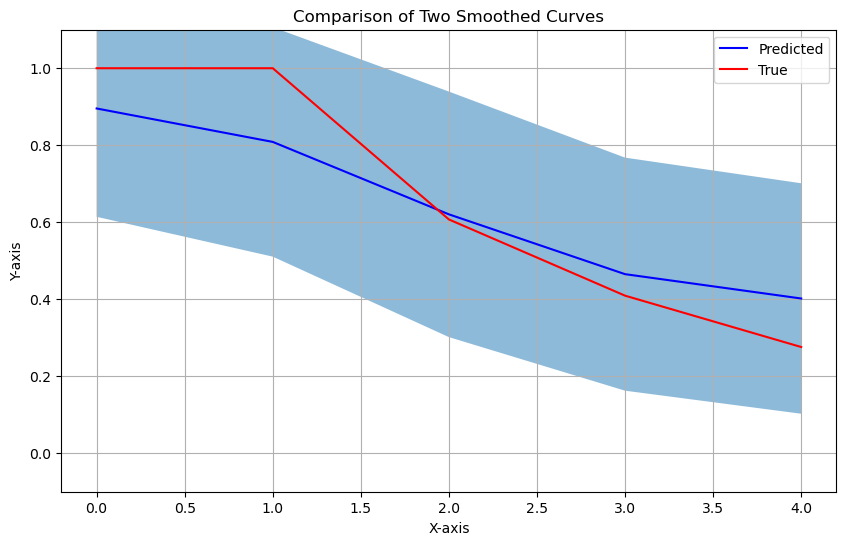

In [75]:

x = np.arange(len(mean[0]))

random_num = np.random.randint(0, len(mean), size=1)[0]
y_pred=mean[random_num]
y_true=y_test_tensor[random_num]
print("Num "+str(random_num)+" Chosen for display")
x = np.linspace(0, len(y_pred) - 1, len(y_pred))
# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label='Predicted', color='blue')
plt.plot(x, y_true, label='True', color='red')
plt.fill_between(x, lower[random_num].numpy(), upper[random_num].numpy(), alpha=0.5)
plt.ylim(-0.1, 1.1)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
